# Marketing Prediction of Bank Offers

The goal of this project is to predict the accepting of an offer from a bank.
The data is related with direct marketing campaigns (phone calls) of a [Portuguese banking institution](https://archive.ics.uci.edu/dataset/222/bank+marketing).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import data processing libraries
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from category_encoders import TargetEncoder,JamesSteinEncoder

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,classification_report
from sklearn.preprocessing import StandardScaler

# import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn_evaluation import plot
import graphviz

import warnings
warnings.filterwarnings('ignore')

In [2]:
# even though its a CSV file but the columns are separated with ';' so use that as separator otherwise it wont load any data since read_csv defaults to ','
bank_df = pd.read_csv("data/bank-additional-full.csv",sep=";")
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Data Analysis

Lets look at the data with some plots using matplotlib and seaborn to see what the story  the data tells.

In [4]:
# check for nulls
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

This dataset has zero null values

In [5]:
bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
# lets check for duplicates
print('Duplicated Row: ',bank_df.duplicated().sum())

Duplicated Row:  12


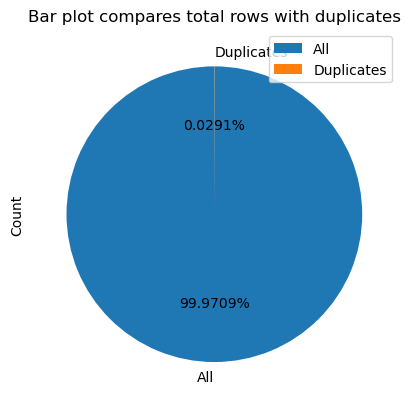

In [7]:
#lets plot the duplicates
labels = ['All', 'Duplicates']
counts = [len(bank_df),len(bank_df[bank_df.duplicated()])]
plt.pie(counts,labels=labels,autopct='%1.4f%%', startangle=90)
plt.title("Bar plot compares total rows with duplicates")
plt.ylabel("Count")
plt.legend()
plt.show()

These seems 12 rows of duplicates in the dataset, lets cleanup these since they will impact the performacne of the model.

This dataset doesnt  have any  null values.

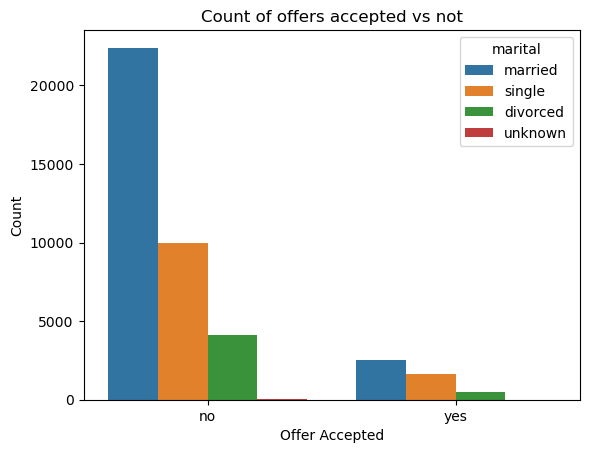

In [8]:
# Check how many people accepted the offer vs not using bar plot with respective to marital status
plt.title("Count of offers accepted vs not")
sns.countplot(bank_df,x='y',hue='marital')
plt.xlabel('Offer Accepted')
plt.ylabel('Count')
plt.show()

The above plot tells that many people didnt accepted offers. The offer acceptance % seems very less compared to total population.

### Accepted Data Analyis

In [9]:
# get the data only for offer accepted
offers_accepted = bank_df.query("y == 'yes'")
offers_accepted.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
129,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
139,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes


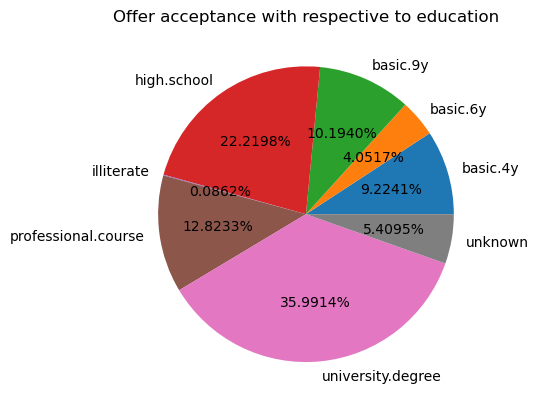

In [10]:
offers_accepted_by_education = offers_accepted.groupby('education').size()
plt.title('Offer acceptance with respective to education')
plt.pie(offers_accepted_by_education,labels=offers_accepted_by_education.index,autopct='%1.4f%%')
plt.show()

People with  university degree accepted the offers alot than other people

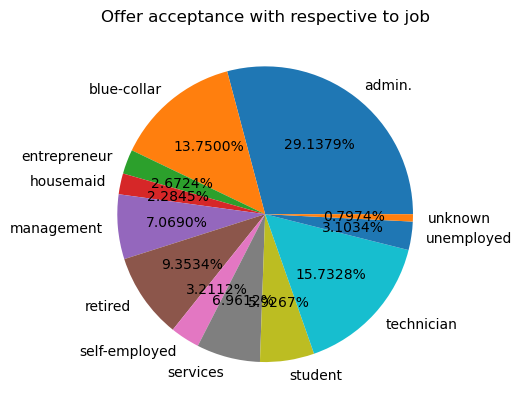

In [11]:
offers_accepted_by_job = offers_accepted.groupby('job').size()
plt.title('Offer acceptance with respective to job')
plt.pie(offers_accepted_by_job,labels=offers_accepted_by_job.index,autopct='%1.4f%%')
plt.show()

It seems pleople are doing admin job are accepted many offers than other people.

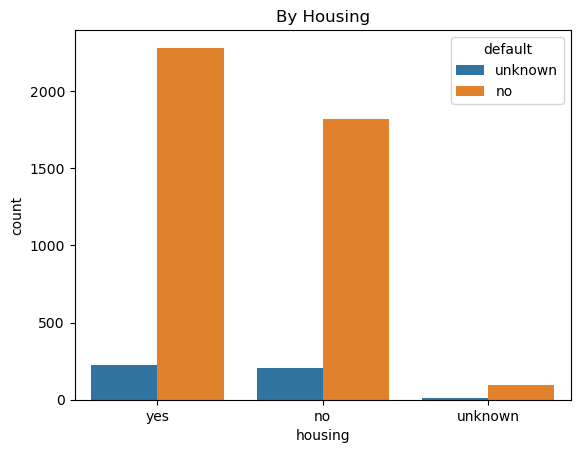

In [12]:
plt.title('By Housing')
sns.countplot(offers_accepted,x = 'housing', hue='default')
plt.show()

<Axes: xlabel='contact', ylabel='age'>

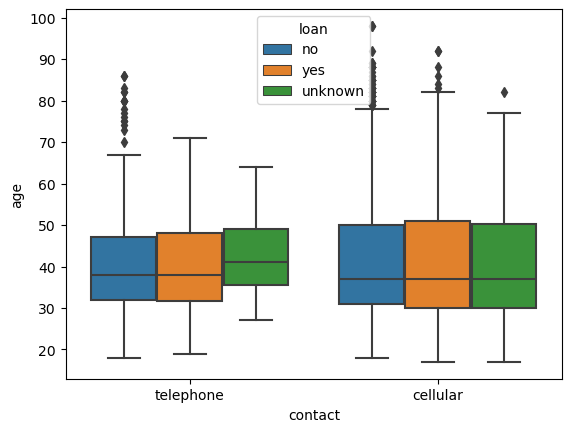

In [13]:
sns.boxplot(data=offers_accepted, x="contact",y="age", hue="loan")

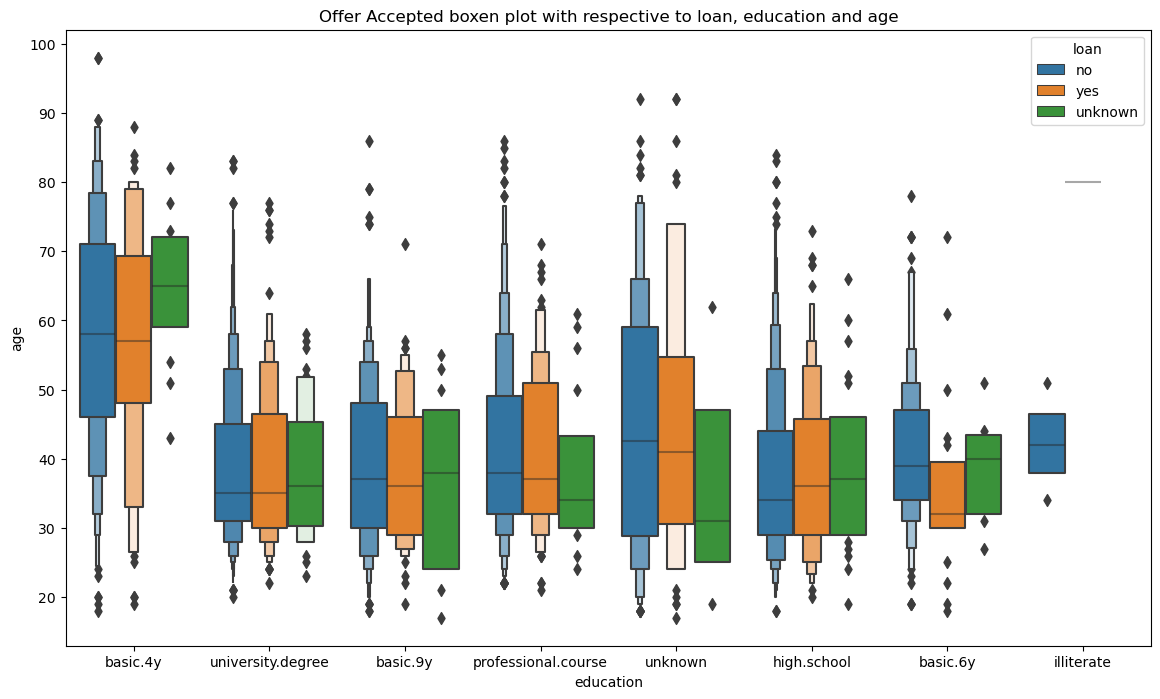

In [14]:
plt.figure(figsize=(14,8))
plt.title("Offer Accepted boxen plot with respective to loan, education and age")
sns.boxenplot(data=offers_accepted, x="education",y="age", hue="loan")
plt.show()

### Run the similar analysis on Full Data Set

## Data Preparation
Lets do the following tasks to clean the data which can be used for modeling
1. Delete duplicates
2. Converting the categorical features into numerical values.
3. Fill/Drop na values

In [15]:
# remove the dupliates
bank_df_processed = bank_df.drop_duplicates()

There seems quite a few categorical features, and in these *education*, *month*, *day_of_week* are ordinal categories for which probably  we need to use **OrinalEncoder** and for other we can use **LabelEncoder**  or **TargetEncoder**

In [16]:
# find out the categorical values of the education  feature to define the order
bank_df_processed['education'].astype('category').values

['basic.4y', 'high.school', 'high.school', 'basic.6y', 'high.school', ..., 'professional.course', 'professional.course', 'university.degree', 'professional.course', 'professional.course']
Length: 41176
Categories (8, object): ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown']

In [17]:
#find out unique values of various features to do encoding with order
print(np.unique(bank_df_processed['month'].astype('category').values))
print(np.unique(bank_df_processed['day_of_week'].astype('category').values))

['apr' 'aug' 'dec' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
['fri' 'mon' 'thu' 'tue' 'wed']


In [18]:
# create ordered categorical values for OrinalEncoding, since we wanted to retain the order of these values
month_values_order=[['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
day_of_week_values_order = [['mon','tue','wed','thu','fri','sat','sun']]
education_values_order = [['unknown','illiterate','basic.4y', 'basic.6y', 'basic.9y', 'high.school','university.degree','professional.course']]

In [19]:
# build pipeline for encoding using column transformer
ordinal_encoder_transformer = make_column_transformer(
    (OrdinalEncoder(categories=education_values_order), ['education']),
    (OrdinalEncoder(categories=month_values_order), ['month']),
    (OrdinalEncoder(categories=day_of_week_values_order), ['day_of_week']),
    remainder='passthrough'  # otherwise it will encode only the above 3 features and drop others
)

#X_encoded = ordinal_encoder_transformer.fit_transform(X)
#X = pd.DataFrame(X_encoded,columns=X.columns)
#X.sample(50, random_state=42)

In [20]:
nominal_columns = ['job','marital','default','housing','loan','contact','poutcome','y']
for col in nominal_columns:
    bank_df_processed[col] = LabelEncoder().fit_transform(bank_df_processed[col])


bank_df_processed.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,basic.4y,0,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,high.school,1,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,high.school,0,2,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,basic.6y,0,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,high.school,0,0,2,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [21]:
ordinal_bank_df = bank_df_processed[['education','month','day_of_week']]
bank_df_processed_encoded = ordinal_encoder_transformer.fit_transform(ordinal_bank_df)
bank_df_encoded = pd.DataFrame(bank_df_processed_encoded,columns=ordinal_bank_df.columns)
bank_df_encoded.head()

,education,month,day_of_week
0,2.0,4.0,0.0
1,5.0,4.0,0.0
2,5.0,4.0,0.0
3,3.0,4.0,0.0
4,5.0,4.0,0.0


In [22]:
bank_df_processed.drop(['education','month','day_of_week'],axis=1, inplace=True)
print(bank_df_processed.head())

   age  job  marital  default  housing  loan  contact  duration  campaign  \
0   56    3        1        0        0     0        1       261         1   
1   57    7        1        1        0     0        1       149         1   
2   37    7        1        0        2     0        1       226         1   
3   40    0        1        0        0     0        1       151         1   
4   56    7        1        0        0     2        1       307         1   

   pdays  previous  poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  \
0    999         0         1           1.1          93.994          -36.4   
1    999         0         1           1.1          93.994          -36.4   
2    999         0         1           1.1          93.994          -36.4   
3    999         0         1           1.1          93.994          -36.4   
4    999         0         1           1.1          93.994          -36.4   

   euribor3m  nr.employed  y  
0      4.857       5191.0  0  
1      4.857

In [23]:
bank_df_encoded_processed = pd.concat([bank_df_processed,bank_df_encoded],axis=1)
bank_df_encoded_processed.head()

,age,job,marital,default,housing,loan,contact,duration,campaign,pdays,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education,month,day_of_week
0,56.0,3.0,1.0,0.0,0.0,0.0,1.0,261.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,2.0,4.0,0.0
1,57.0,7.0,1.0,1.0,0.0,0.0,1.0,149.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,5.0,4.0,0.0
2,37.0,7.0,1.0,0.0,2.0,0.0,1.0,226.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,5.0,4.0,0.0
3,40.0,0.0,1.0,0.0,0.0,0.0,1.0,151.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,3.0,4.0,0.0
4,56.0,7.0,1.0,0.0,0.0,2.0,1.0,307.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,5.0,4.0,0.0


In [24]:
# there are only few rows with na values so delete them
bank_df_encoded_processed.dropna(inplace=True)
bank_df_encoded_processed.isna().sum()

age               0
job               0
marital           0
default           0
housing           0
loan              0
contact           0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
education         0
month             0
day_of_week       0
dtype: int64

## Modeling

Now we have the dataset processed, so lets build some classifications models to see how the performance of various models and see how we can fine tune the models.

### Data for model
Lets get the data ready for the model train and testing

In [25]:
X = bank_df_encoded_processed.drop('y',axis=1)
y=bank_df_encoded_processed['y']

# apply standard scaler
X = StandardScaler().fit_transform(X)

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

<Axes: title={'center': 'Class Balance for 41,164 Instances'}, ylabel='support'>

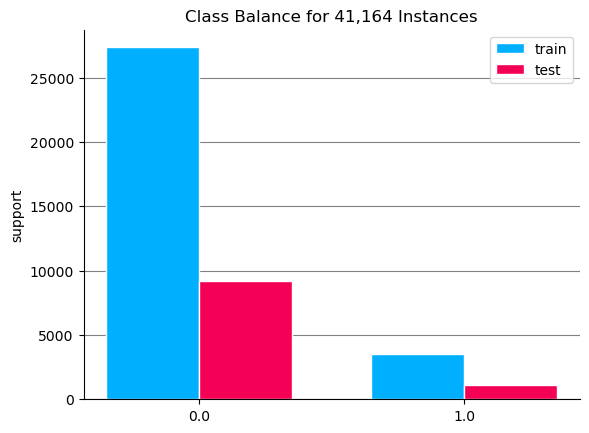

In [27]:
plot.target_analysis(y_train, y_test)

In [28]:
# create two dictionaries to keep track of traning and testing performance or various models
train_performance = {}
test_performance = {}

### Logistic Regression
Build Logistic Regression models and see how it performs

In [29]:
# lets build a basic logistic regression model and evaluate the performance
lgr = LogisticRegression().fit(X_train,y_train)
train_score = lgr.score(X_train,y_train)
test_score= accuracy_score(y_test,lgr.predict(X_test))
train_performance['LGR'] = train_score
test_performance['LGR'] = test_score
print(train_score,test_score)

0.9106338872153662 0.9134194927606647


The basic logistic regression model score is 91% for both training and testing datasets which is really good. Lets see if we can improve further by looking at other techniques like cross validation and tuning hyper parameters.

**One important observation** is that trainig and testing score is pretty close which means that this model is not overfitting.

In [30]:
# build a cross validation with 5 folds and see how the model performs
cv_scores = cross_val_score(lgr,X_train,y_train,cv=5,scoring='accuracy')
cv_scores.mean()

0.9100832772669507

With 5 folds cross validation the model didnt improved much compared to base model.

#### Hyper Parameter Tuning
Tune the hyper parameters of logistic regression using GridSearchCV and evaluate the model performance

In [31]:
log_reg = LogisticRegression()
parameters = {
    "penalty":["l1", "l2", "elasticnet"],
    "C": [10,50,100],
    "max_iter": [10,50,100],
    "solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
lgr_gridSearchCV = GridSearchCV(log_reg,param_grid=parameters, scoring="accuracy", cv=5).fit(X_train,y_train)
gs_train_score = lgr_gridSearchCV.score(X_train,y_train)
gs_test_Score = lgr_gridSearchCV.score(X_test,y_test)
train_performance['LGR_GRIDSEARCH'] = gs_train_score
test_performance['LGR_GRIDSEARCH'] = gs_test_Score

print("Train Score: ",gs_train_score, "Test Score: ", gs_test_Score)

Train Score:  0.9110873578855311 Test Score:  0.913030803614809


The score of grid search cv is close to the base model so hyper parameter tuning is not helping much.

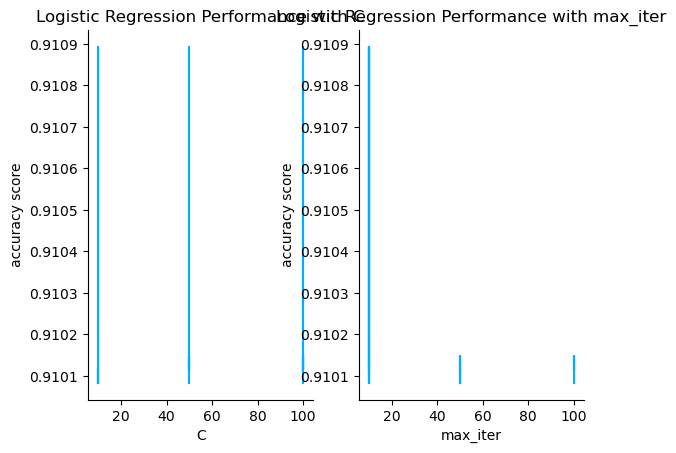

In [32]:
# create a dataframe of GridSearchCV results and plot the results
gs_df = pd.DataFrame(lgr_gridSearchCV.cv_results_,columns=lgr_gridSearchCV.cv_results_.keys())

plt.subplot(1, 2, 1)
plt.title('Logistic Regression Performance with C')
plt.plot(gs_df['param_C'],gs_df['mean_test_score'])
plt.xlabel("C")
plt.ylabel("accuracy score")

plt.subplot(1, 2, 2)
plt.title("Logistic Regression Performance with max_iter")
plt.plot(gs_df['param_max_iter'],gs_df['mean_test_score'])
plt.xlabel("max_iter")
plt.ylabel("accuracy score")

plt.show()

In [33]:
# create a function for confusion matrix plot
def plot_confusion_matrix(y_true,y_predict,gs): 
    cm = confusion_matrix(y_true,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gs.classes_)
    disp.plot() 

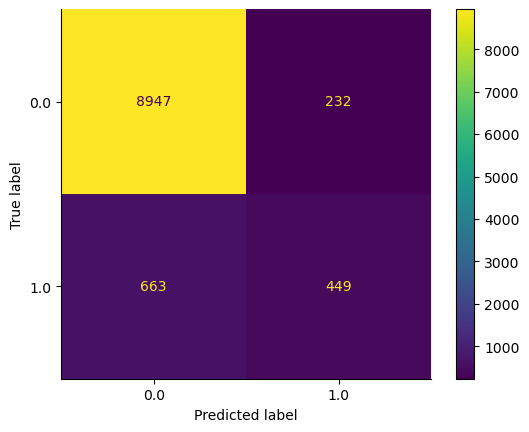

In [34]:
plot_confusion_matrix(y_test,lgr_gridSearchCV.predict(X_test),lgr_gridSearchCV)

The error predictions are 232+663 which is 895 rows

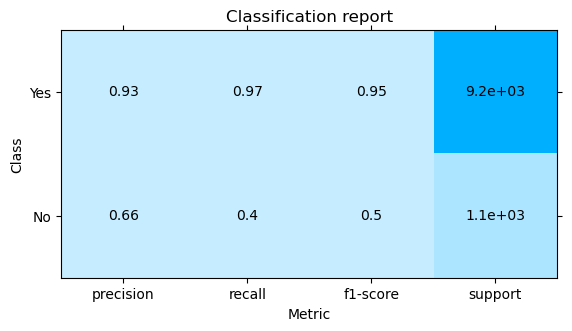

In [35]:
plot.ClassificationReport.from_raw_data(
    y_test,lgr_gridSearchCV.predict(X_test), target_names=["Yes","No"]
)

### KNN
Lets evaluate KNN Classifier model on this dataset and evaluate the performance

In [36]:
# apply default KNN Classifier and check the performance
knn  = KNeighborsClassifier().fit(X_train,y_train)
knn_train_score = knn.score(X_train,y_train)
knn_test_score = knn.score(X_test,y_test)
train_performance['KNN'] = knn_train_score
test_performance['KNN'] = knn_test_score
print("Accuracy Score: ",accuracy_score(y_test,knn.predict(X_test)))


Accuracy Score:  0.9016616460985327


Now lets figure out the best *n_neighbours* by using the cross validation technique.

In [37]:
knn_cv = KNeighborsClassifier()
params = {
    "n_neighbors": np.array(range(1,50))
}

gridSearchCV = GridSearchCV(estimator=knn_cv,param_grid=params,cv=5,scoring="accuracy").fit(X_train,y_train)
knn_grid_train_score = gridSearchCV.score(X_train,y_train)
knn_grid_test_score = gridSearchCV.score(X_test,y_test)
train_performance['KNN_GRID'] = knn_grid_train_score
test_performance['KNN_GRID'] = knn_grid_test_score
print(knn_grid_train_score)
print(gridSearchCV.best_estimator_)

0.9082369708159233
KNeighborsClassifier(n_neighbors=26)


Text(0, 0.5, 'accuracy score')

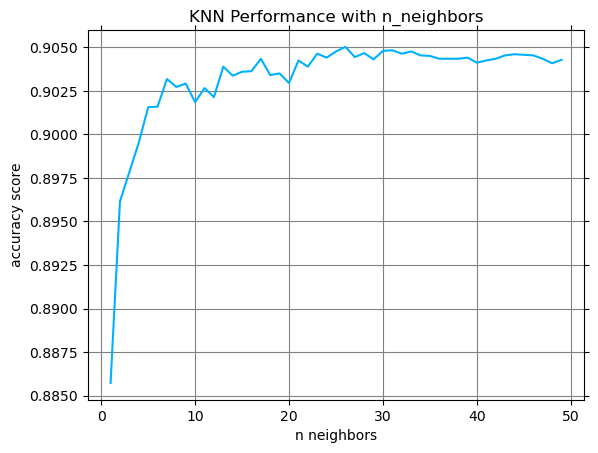

In [38]:
# create a dataframe of GridSearchCV results
gs_df = pd.DataFrame(gridSearchCV.cv_results_,columns=gridSearchCV.cv_results_.keys())

plt.title('KNN Performance with n_neighbors')
plt.plot(gs_df['param_n_neighbors'],gs_df['mean_test_score'])
plt.grid()
plt.xlabel("n neighbors")
plt.ylabel("accuracy score")

After tuning hyper parameter with GridSearchCV cross validation technique the model improved little bit. Best n_neighbors for this dataset is **26** which yeilds the best score

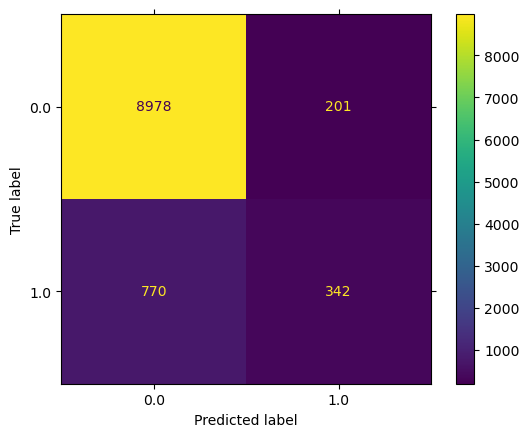

In [39]:
# Lets visualize using confusion matrix data
cm = confusion_matrix(y_test,gridSearchCV.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gridSearchCV.classes_)
disp.plot()

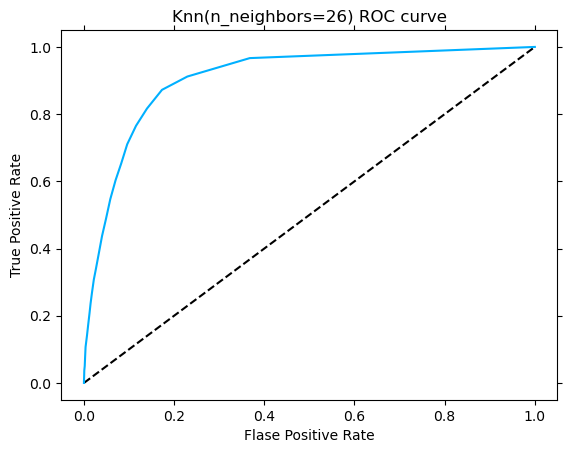

In [40]:
# Lets evaluate roc curve score
y_pred_proba = gridSearchCV.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Knn(n_neighbors=26) ROC curve')
plt.show()

In [41]:
roc_auc_score(y_test,y_pred_proba)

0.907165176454544

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      9179
         1.0       0.63      0.31      0.41      1112

    accuracy                           0.91     10291
   macro avg       0.78      0.64      0.68     10291
weighted avg       0.89      0.91      0.89     10291



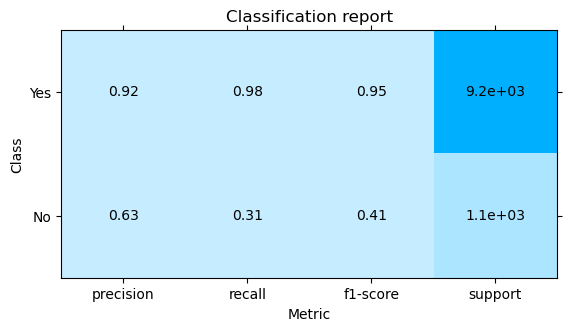

In [42]:
print(classification_report(y_test,gridSearchCV.predict(X_test)))


plot.ClassificationReport.from_raw_data(
    y_test, gridSearchCV.predict(X_test), target_names=["Yes","No"]
)

# see - https://github.com/ploomber/sklearn-evaluation

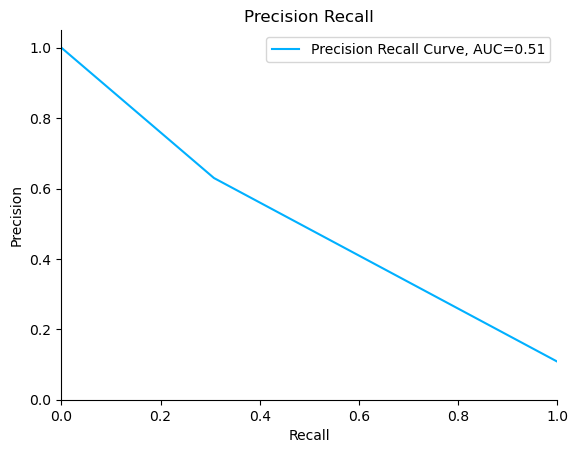

In [43]:
plot.PrecisionRecall.from_raw_data(y_test, gridSearchCV.predict(X_test))

### Decision Trees
Lets evaluate the decision tree models on this dataset and evaluate the performance

In [44]:
d_tree = DecisionTreeClassifier(random_state=42).fit(X_train,y_train)
train_tree_score = d_tree.score(X_train,y_train)
test_tree_score = accuracy_score(y_test,d_tree.predict(X_test))
print(train_tree_score,test_tree_score)
train_performance['DTREE'] = train_tree_score
test_performance['DTREE'] = test_tree_score

1.0 0.891555728306287


In [45]:
gs_tree = DecisionTreeClassifier()
parameter = {
"max_depth": np.array(range(1,50))
}
tree_gridsearch = GridSearchCV(gs_tree, param_grid=parameter).fit(X_train,y_train)

train_tree_gs_score = tree_gridsearch.score(X_train,y_train)
test_tree_gs_score = accuracy_score(y_test,tree_gridsearch.predict(X_test))

train_performance['DTREE_GS'] = train_tree_gs_score
test_performance['DTREE_GS'] = test_tree_gs_score


In [46]:
tree_gridsearch.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Text(0, 0.5, 'accuracy score')

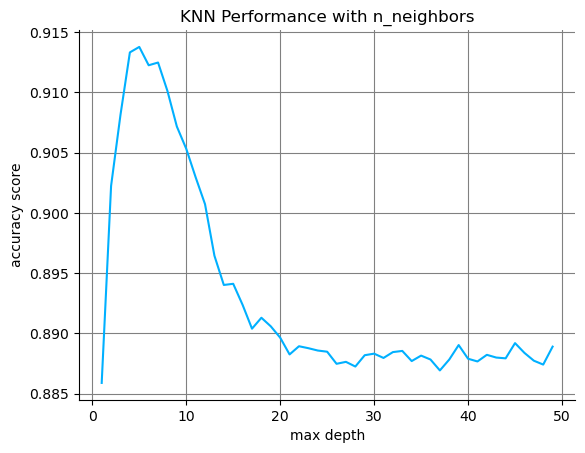

In [47]:
gs_df = pd.DataFrame(tree_gridsearch.cv_results_,columns=tree_gridsearch.cv_results_.keys())

plt.title('KNN Performance with n_neighbors')
plt.plot(gs_df['param_max_depth'],gs_df['mean_test_score'])
plt.grid()
plt.xlabel("max depth")
plt.ylabel("accuracy score")

In [48]:
accuracy_score(y_test,tree_gridsearch.predict(X_test))

0.9156544553493343

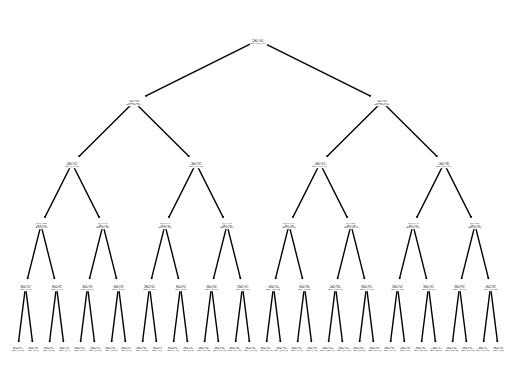

In [49]:

tree.plot_tree(tree_gridsearch.best_estimator_)
plt.show()

## SVM
Lets evaluate SVM performance on this dataset

In [50]:
svc = SVC().fit(X_train,y_train)
svc_train_score = svc.score(X_train,y_train)
svc_test_score = accuracy_score(y_test,svc.predict(X_test))

train_performance['SVC'] = svc_train_score
test_performance['SVC'] = svc_test_score


## Model Evaluation
Lets evaluate each model performance and see which model does best and which we can use for this use case.

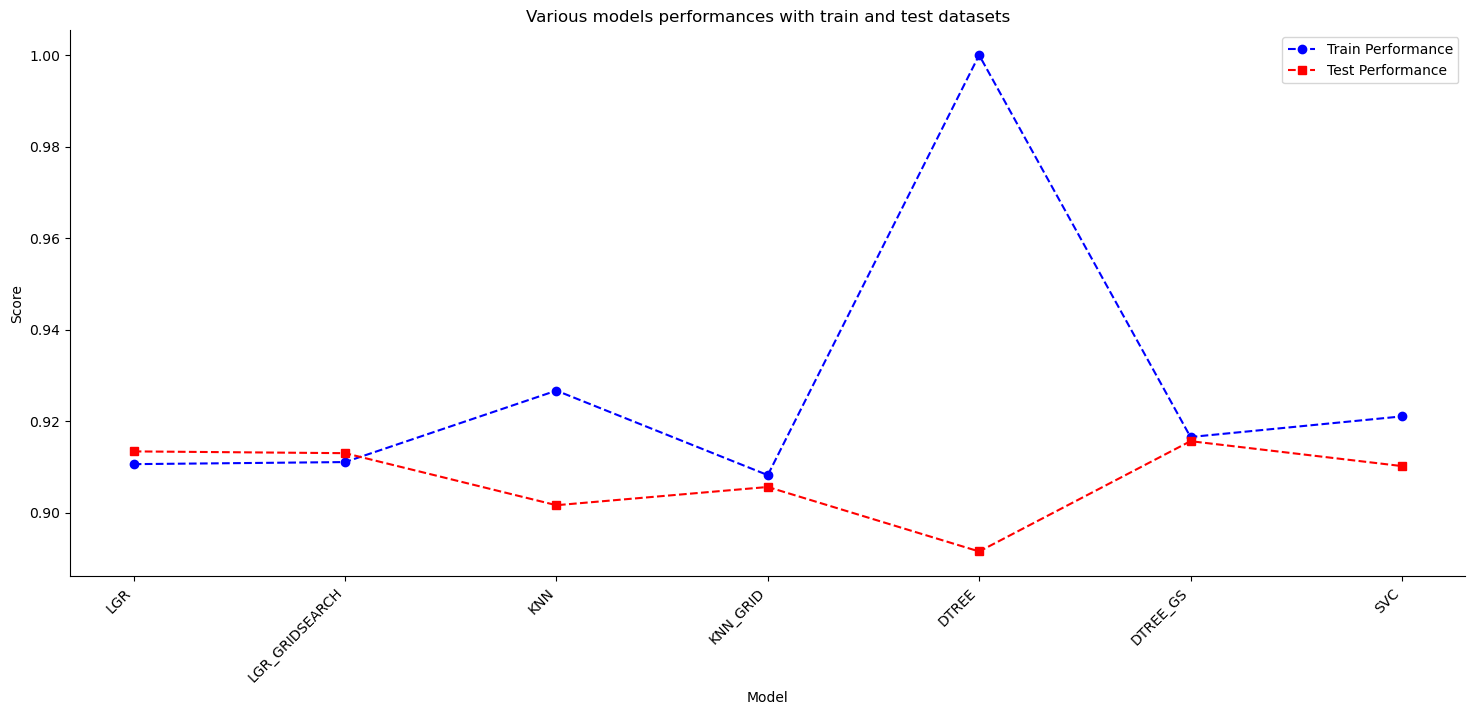

In [51]:
fig = plt.figure(figsize=(18,7))
plt.title("Various models performances with train and test datasets")
plt.plot(train_performance.keys(), train_performance.values(),label="Train Performance",linestyle='--', marker='o', color='b')
plt.plot(test_performance.keys(),test_performance.values(),label="Test Performance",linestyle='--', marker='s', color='r')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.xlabel("Model")
plt.ylabel("Score")
spacing = 0.100
fig.subplots_adjust(bottom=spacing)
plt.show()